# # Analyze Benchmarking Results for Multi Value LsmTree Storage Engine


In [1]:
import os.path
from collections import defaultdict
from functools import partial
from glob import glob

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import display

from dbf0util import (configure_notebook, colors, format_number, add_bar_values,
                      compute_rate, time_plot, create_mask, combine_masks,
                      read_tdigest, tdigest_merge, compute_centroids, plot_centroids_cdf,
                      to_html, load_pickle)
from dbf0util import savefig as util_savefig

configure_notebook()

# Constants

In [2]:
results_base_dir = 'results/mv_doc'
!ls $results_base_dir

author_count.txt  file_sizes.csv  get  load  subreddit_count.txt


In [3]:
intermediate_base_dir = 'intermediate/multivalue_lsm'
!mkdir -p $intermediate_base_dir

In [4]:
figdir = 'figures/multivalue_lsm'
!rm -r $figdir
!mkdir -p $figdir

# Utilities

In [5]:
def read_results(directory, name_attr_extractor):
    results = []
    for path in glob(results_base_dir + '/' + directory + '/*.jsonl'):
        attrs = name_attr_extractor(os.path.splitext(os.path.basename(path))[0])
        x = pd.read_json(path, lines=True)
        x['time'] = (x['time'] - x['time'].iloc[0]) / 1e9
        attrs['results'] = x
        results.append(attrs)
    return pd.DataFrame(results)

In [6]:
def min_duration(df):
    return df.loc[df['duration'].idxmin()]

In [7]:
savefig = partial(util_savefig, figdir=figdir)

# Analyzing Keys

In [8]:
def read_key_counts(name):
    key_counts = pd.read_csv(f'{results_base_dir}/{name}_count.txt', sep='=', names=['key', 'count'], header=None)
    key_counts = key_counts.sort_values('count', ascending=True).reset_index().drop(['index'], axis=1)
    x = key_counts.rename(columns={'key':name, 'count':'Count'}).tail().iloc[::-1].copy()
    x['Count'] = x['Count'].map('{:,}'.format)
    display(x)
    print(to_html(x))
    return key_counts

In [9]:
subreddit_count = read_key_counts('subreddit')

,subreddit,Count
151004,AskReddit,"7,764,782"
151003,memes,"2,011,934"
151002,teenagers,"1,977,753"
151001,politics,"1,962,575"
151000,dankmemes,"1,683,921"


<table border="1" class="dataframe"> <thead> <tr style="text-align: right;"> <th>subreddit</th> <th>Count</th> </tr> </thead> <tbody> <tr> <td>AskReddit</td> <td>7,764,782</td> </tr> <tr> <td>memes</td> <td>2,011,934</td> </tr> <tr> <td>teenagers</td> <td>1,977,753</td> </tr> <tr> <td>politics</td> <td>1,962,575</td> </tr> <tr> <td>dankmemes</td> <td>1,683,921</td> </tr> </tbody> </table>


In [10]:
author_count = read_key_counts('author')

,author,Count
7044847,[deleted],"13,984,910"
7044846,AutoModerator,"2,059,516"
7044845,KeepingDankMemesDank,"206,701"
7044844,Edgar_The_Pug_Bot,"194,661"
7044843,transcribot,"87,577"


<table border="1" class="dataframe"> <thead> <tr style="text-align: right;"> <th>author</th> <th>Count</th> </tr> </thead> <tbody> <tr> <td>[deleted]</td> <td>13,984,910</td> </tr> <tr> <td>AutoModerator</td> <td>2,059,516</td> </tr> <tr> <td>KeepingDankMemesDank</td> <td>206,701</td> </tr> <tr> <td>Edgar_The_Pug_Bot</td> <td>194,661</td> </tr> <tr> <td>transcribot</td> <td>87,577</td> </tr> </tbody> </table>


In [11]:
subreddit_entries = subreddit_count['count'].sum()
author_entries = author_count['count'].sum()
assert subreddit_entries == author_entries
entries = subreddit_entries
f'{entries:.2e}'

'1.47e+08'

In [12]:
def compute_key_stats(key_counts, name):
    x =  (key_counts['count']
            .rename(name)
            .describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95, 0.99, 0.999, 0.9999])
            .drop(['std'])
            .rename({'mean': 'Mean', 'count': 'Key Count', 'min':'Min', 'max':'Max'})
            .to_frame().T)
    for c in set(x.columns) - {'Mean'}:
        x[c] = x[c].astype(int).map('{:,}'.format)
    x['Mean'] = x['Mean'].map('{:.1f}'.format)
    return x


key_stats = pd.concat([
    compute_key_stats(subreddit_count, 'subreddit'),
    compute_key_stats(author_count, 'author')
]).reset_index().rename(columns={'index':'Key'})
print(to_html(key_stats))
key_stats

<table border="1" class="dataframe"> <thead> <tr style="text-align: right;"> <th>Key</th> <th>Key Count</th> <th>Mean</th> <th>Min</th> <th>25%</th> <th>50%</th> <th>75%</th> <th>90%</th> <th>95%</th> <th>99%</th> <th>99.9%</th> <th>99.99%</th> <th>Max</th> </tr> </thead> <tbody> <tr> <td>subreddit</td> <td>151,005</td> <td>972.5</td> <td>1</td> <td>1</td> <td>5</td> <td>34</td> <td>331</td> <td>1,385</td> <td>14,575</td> <td>128,401</td> <td>701,832</td> <td>7,764,782</td> </tr> <tr> <td>author</td> <td>7,044,848</td> <td>20.8</td> <td>1</td> <td>1</td> <td>4</td> <td>12</td> <td>39</td> <td>77</td> <td>246</td> <td>747</td> <td>1,802</td> <td>13,984,910</td> </tr> </tbody> </table>


,Key,Key Count,Mean,Min,25%,50%,75%,90%,95%,99%,99.9%,99.99%,Max
0,subreddit,"151,005",972.5,1,1,5,34,331,"1,385","14,575","128,401","701,832","7,764,782"
1,author,"7,044,848",20.8,1,1,4,12,39,77,246,747,"1,802","13,984,910"


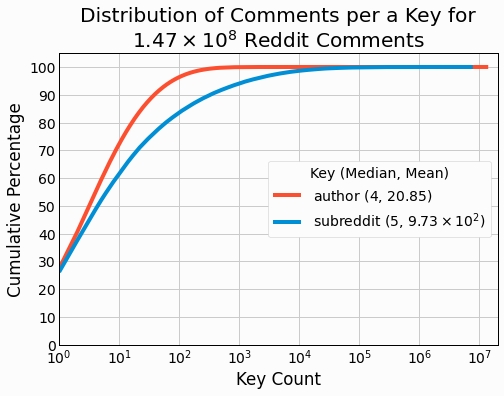

In [13]:
def plot_key_cdf(key_counts, color, label, ax):
    key_count_counts = (key_counts['count']
                        .value_counts()
                        .to_frame()
                        .sort_index()
                        .reset_index()
                        .rename(columns={'index':'key_count'}))
    key_count_counts['cum_frac'] = (key_count_counts['count'].cumsum() / 
                                    key_count_counts['count'].sum())
    key_count_counts['cum_perc'] = key_count_counts['cum_frac'] * 100
   
    def perc(p):
        assert 0 <= p <= 100
        return  key_count_counts['key_count'][key_count_counts['cum_frac'] >= (p/100.0)].iloc[0]
        

    x = key_count_counts
    mn = (x['key_count'] * x['count']).sum() / x['count'].sum()
    x.plot('key_count', 'cum_perc', style='-', ax=ax, color=color,
           label=f'{label} ({int(perc(50))}, {format_number(mn)})')


with plt.rc_context({'axes.edgecolor':'k', 'axes.linewidth':1}):
    fig = plt.figure(figsize=(7,5))
    ax = fig.add_subplot(111)
    
    plot_key_cdf(author_count, colors[1], 'author', ax)
    plot_key_cdf(subreddit_count, colors[0], 'subreddit', ax)

    ax.set_xscale('log')
    ax.set_xlim(1, 2e7)
    ax.set_ylim(0, 105)
    ax.set_yticks(np.arange(0, 101, 10))
    ax.set_xlabel('Key Count')
    ax.set_ylabel('Cumulative Percentage')
    ax.set_title(f'Distribution of Comments per a Key for\n{format_number(entries)} Reddit Comments')
    ax.legend(loc='center right', ncol=1, title='Key (Median, Mean)', framealpha=1)

    savefig('reddit_comment_key_count_dist')

# Analyzing Loading

In [14]:
def extract_load_attrs(name):
    key_attr, value_attr, *rest = name.split('_')
    index_rate, partitions, threads = map(int,rest)
    return {'key_attr': key_attr, 'value_attr': value_attr, 'index_rate': index_rate,
            'partitions':partitions, 'threads':threads}

load_results = read_results('load', extract_load_attrs)
load_results.sample(5)

,key_attr,value_attr,index_rate,partitions,threads,results
21,author,id,10,8,16,time writes size 0 0.000000 621503 0 1 1.068804 ...
18,author,id,10,4,2,time writes size 0 0.000000 681119 0 1 1.048744 ...
1,author,id,5,4,8,time writes size 0 0.000000 677164 0 1 1.064836 ...
31,subreddit,id,50,8,32,time writes size 0 0.000000 631562 0 1 1.049830 ...
29,author,id,10,1,4,time writes size 0 0.000000 607970 0 1 1.048668 ...


,count,mean,std,min,25%,50%,75%,max
duration,58.0,3.959267,0.582726,2.713922,3.587866,3.873633,4.220431,5.255999


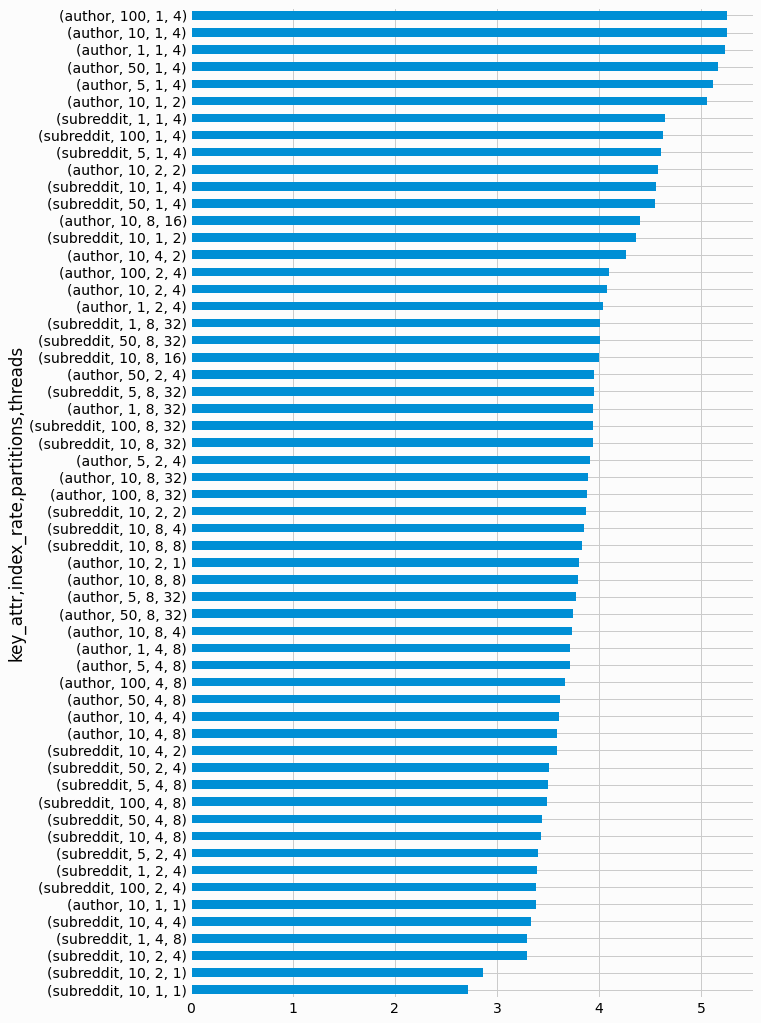

In [15]:
load_results['duration'] = load_results['results'].map(lambda x: x['time'].iloc[-1] - x['time'].iloc[0])
display(load_results['duration'].div(60).describe().to_frame().T)
(load_results
 .set_index(['key_attr', 'index_rate', 'partitions', 'threads'])
 ['duration'].div(60).sort_values()
 .plot.barh(figsize=(9,17)))

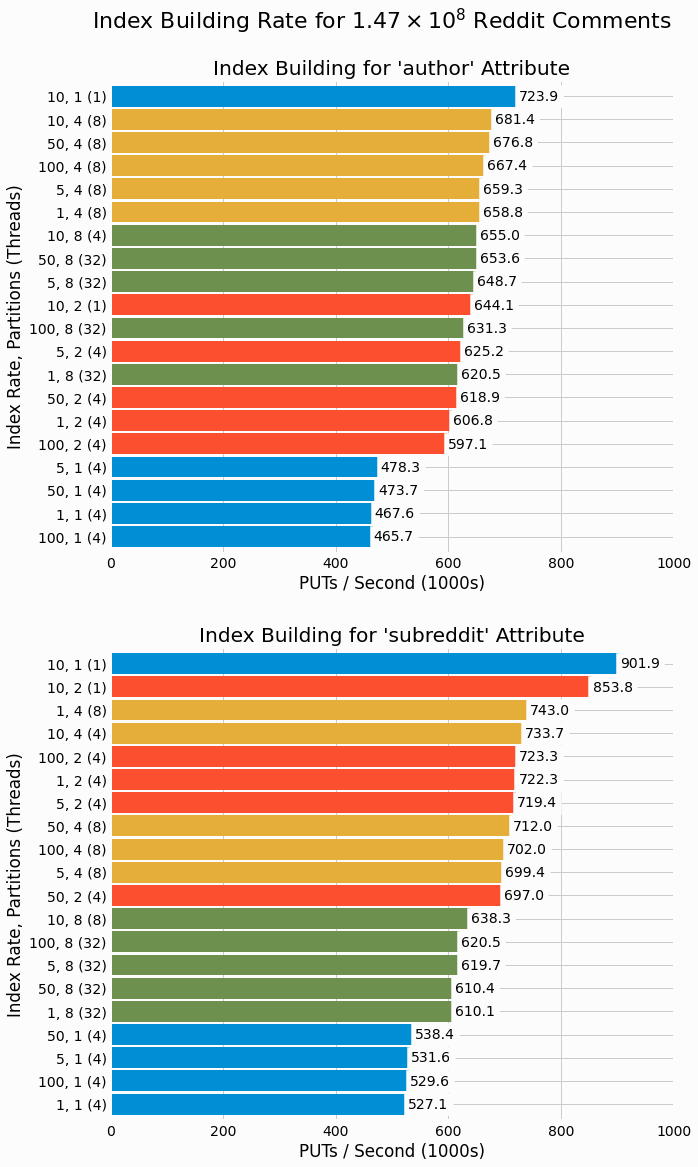

In [16]:
load_results['rate'] = entries / load_results['duration']
fig = plt.figure(figsize=(9,17))

for i,(key_attr, df) in enumerate(load_results.groupby('key_attr')):
    df = (df.groupby(['index_rate', 'partitions'])
          .apply(lambda g: min_duration(g).drop(['index_rate', 'partitions']))
          .sort_values('rate'))
    x = df['rate'].div(1000)
    p = df.reset_index()['partitions']
    ax = fig.add_subplot(2, 1, 1 + i)
    x.plot.barh(color=p.map(dict(zip(sorted(set(p)), colors))), ax=ax, width=0.9)
    add_bar_values(ax, x)
    ax.set_yticklabels(df.reset_index().apply(
        (lambda r: f'{r["index_rate"]}, {r["partitions"]} ({r["threads"]})'), axis=1))
    ax.set_ylabel('Index Rate, Partitions (Threads)')
    ax.set_xlabel('PUTs / Second (1000s)')
    ax.set_title(f"Index Building for '{key_attr}' Attribute")
    ax.set_xlim(0, 1000)
fig.suptitle(f'Index Building Rate for {format_number(entries)} Reddit Comments', size=22)
fig.subplots_adjust(top=0.92)
savefig('load_rate')

In [17]:
load_partition_min_duration = (
    load_results.groupby(['key_attr', 'index_rate', 'partitions'])
    .apply(min_duration)
    .drop(['key_attr', 'index_rate', 'partitions'], axis=1)
)
load_partition_min_duration.sample(5)

value_attr  threads                                                                                              results    duration           rate
key_attr  index_rate partitions                                                                                                                                                    
subreddit 5          4                  id        8             time     writes        size
0      0.000000     671229           0
1      1.054717   ...  209.984698  699357.567977
          10         8                  id        8             time     writes        size
0      0.000000     687323           0
1      1.047514   ...  230.068012  638308.589027
          100        1                  id        4             time     writes        size
0      0.000000     538179           0
1      1.072674   ...  277.281457  529622.101065
author    5          4                  id        8             time     writes        size
0      0.000000     677164           0
1      1.064836   ...  222.741206  659304.988409
subreddit 50         8                  id       32             time     writes        size
0      0.000000     631562           0
1      1.049830   ...  240.585776  610403.450880

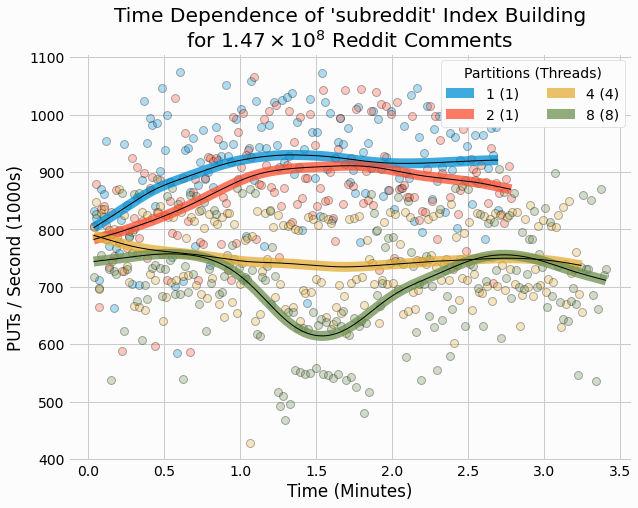

In [18]:
def drop_last_result(df):
    df = df.copy()
    df['results'] = df['results'].map(lambda r: r.iloc[:-1:])
    return df

time_plot(drop_last_result(compute_rate(load_partition_min_duration.loc['subreddit', 10], 'writes')),
          y_col='writes', y_scale=1e-3,
          label_func=lambda partitions, row: f'{partitions} ({row["threads"]})')

plt.ylabel('PUTs / Second (1000s)')
plt.legend(loc='upper right', ncol=2, title='Partitions (Threads)', framealpha=1)
plt.xlabel('Time (Minutes)')
plt.title(f'Time Dependence of \'subreddit\' Index Building\nfor {format_number(entries)} Reddit Comments')
savefig('load_time_dependence_subreddit_index10')

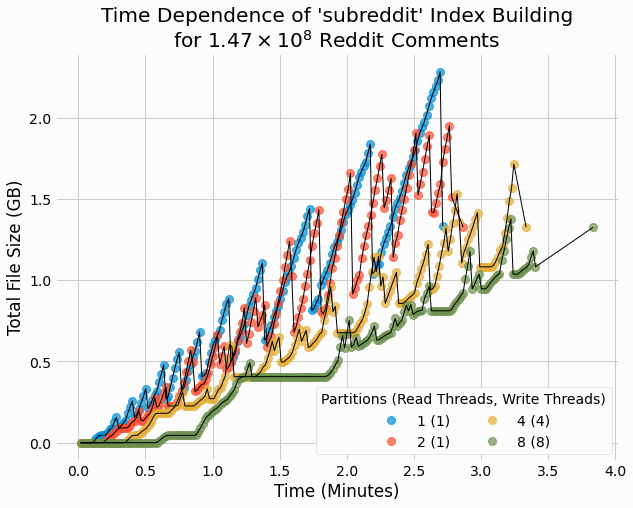

In [19]:


time_plot(load_partition_min_duration.loc['subreddit', 10],
          y_col='size', y_scale=1e-9, spline=False,
          label_func=lambda partitions, row: f'{partitions} ({row["threads"]})')

plt.ylabel('Total File Size (GB)')
plt.legend(loc='lower right', ncol=2, title='Partitions (Read Threads, Write Threads)', framealpha=1)
plt.xlabel('Time (Minutes)')
plt.title(f'Time Dependence of \'subreddit\' Index Building\nfor {format_number(entries)} Reddit Comments')
savefig('load_time_dependence_size_subreddit_index10')

Text(0.5, 1.0, 'Time Dependence of Index Building\nfor 146.9 Million Reddit Comments')

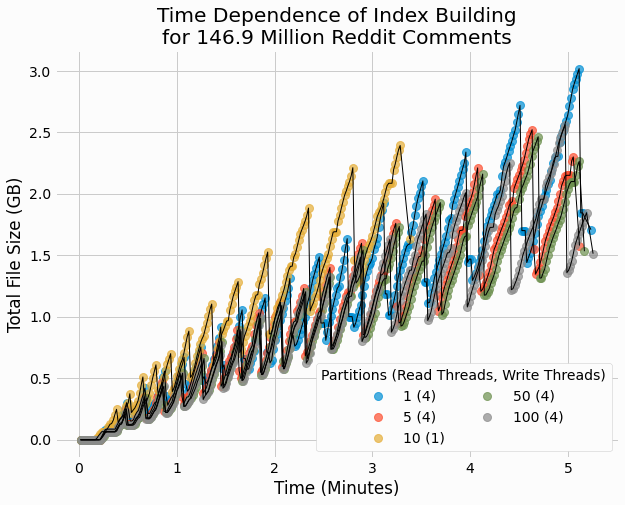

In [20]:
time_plot(load_partition_min_duration.loc['author', ::, 1].reset_index().set_index('index_rate'),
          y_col='size', y_scale=1e-9, spline=False,
          label_func=lambda index_rate, row: f'{index_rate} ({row["threads"]})')

plt.ylabel('Total File Size (GB)')
plt.legend(loc='lower right', ncol=2, title='Partitions (Read Threads, Write Threads)', framealpha=1)
plt.xlabel('Time (Minutes)')
plt.title(f'Time Dependence of Index Building\nfor {entries/1e6:.1f} Million Reddit Comments')

# Analyzing Get

In [21]:
!ls $results_base_dir/get

results.jsonl  specs.jsonl


In [22]:
intermediate_get_path = intermediate_base_dir + '/get_results.p'


def convert_stats(stats):
    if not stats:
        return pd.DataFrame([], columns=['floor', 'count', 't_digest'])
    stats = pd.DataFrame(stats)
    if 'tDigtest' in stats.columns:
        stats = stats.rename(columns={'tDigtest':'tDigest'})
    stats['t_digest'] = stats['tDigest'].map(read_tdigest)
    stats = stats.drop(['tDigest'], axis=1)
    return stats[['floor', 'count', 't_digest']]

def combine_stats(stats):
    acc_floor = defaultdict(list)
    for floor_stats in stats:
        if len(floor_stats):
            for _, stat in floor_stats.iterrows():
                acc_floor[stat['floor']].append(stat['t_digest'])
    return pd.DataFrame([{'floor':f, 't_digest': tdigest_merge(tds)}
                         for f, tds in acc_floor.items()])
    
    
def aggregate_results(df):
    df['time'] = (df['nano_time'] - df['nano_time'].min()) / 1e9
    df = df.drop(['nano_time', 'spec_id'], axis=1)
    df = df.sort_values('time')
    df['stats'] = df['stats'].map(convert_stats)
    return pd.Series({
        'results': df,
        'duration': df['time'].iloc[-1],
        'get_keys': df['get_keys'].iloc[-1],
        'get_values': df['get_values'].iloc[-1],
        'file_size': df['file_size'].iloc[-1],
        'total_stats': combine_stats(df['stats'])
    })

if 'get_results' in globals():
    print('skipping time consuming loading of get_results since it already exists')
elif os.path.exists(intermediate_get_path):
    print('loading get_results from disk')
    get_results = load_pickle(intermediate_get_path)
else:
    print('computing get_results from raw data. this may take a while')
    get_specs = pd.read_json(results_base_dir + '/get/specs.jsonl', lines=True)
    get_specs = pd.concat([get_specs.drop('spec', axis=1),
                           pd.DataFrame(list(get_specs['spec']), index=get_specs.index)], axis=1)
    print(len(get_specs))
    
    get_results_entries = pd.read_json(results_base_dir + '/get/results.jsonl', lines=True, convert_dates=False)
    print(len(get_results_entries))
    get_results_entries.sample(5)

    get_results = get_results_entries.groupby('spec_id').progress_apply(aggregate_results)
    get_results = pd.concat([get_specs.set_index('id'), get_results], axis=1)
    get_results.to_pickle(intermediate_get_path)

get_results.sample(5)

intermediate/multivalue_lsm/get_results.p:   0%|          | 0.00/213M [00:00<?, ?B/s]

loading get_results from disk


intermediate/multivalue_lsm/get_results.p: 100%|██████████| 213M/213M [00:38<00:00, 5.57MB/s] 


,created_at,events,last_modified,status,partitions,duration_seconds,report_frequency_seconds,key_attr,trial_index,index_rate,thread_count,results,duration,get_keys,get_values,get_key_rate,get_value_rate,file_size,total_stats
9c744104-9c37-11ea-8269-00155d010301,2020-05-22 14:22:05.179599,"[{'msg': 'starting', 'hostname': 'ec2-34-221-48-148.us-west-2.compute.amazonaws.com', 'time': '2...",2020-05-22T16:12:38.911766,succeeded,1,300,10,subreddit,0,1,1,...,299.999129,3935867,3735092754,13119.594750,1.245035e+07,1326647775,floor ...
98fdd53a-9c37-11ea-8269-00155d010301,2020-05-22 14:21:59.371957,"[{'msg': 'starting', 'hostname': 'ec2-18-237-217-2.us-west-2.compute.amazonaws.com', 'time': '20...",2020-05-22T16:32:43.051975,succeeded,1,300,10,subreddit,0,50,8,...,300.072692,3536559,3407688962,11785.674265,1.135621e+07,1323944936,floor ...
9edca18e-9c37-11ea-8269-00155d010301,2020-05-22 14:22:10.787779,"[{'msg': 'starting', 'hostname': 'ec2-34-221-48-148.us-west-2.compute.amazonaws.com', 'time': '2...",2020-05-22T15:57:36.647733,succeeded,1,300,10,author,0,10,32,...,299.999363,200696138,4079636747,668988.546118,1.359882e+07,1426274143,floor ...
9edca182-9c37-11ea-8269-00155d010301,2020-05-22 14:22:09.858328,"[{'msg': 'starting', 'hostname': 'ec2-54-190-65-4.us-west-2.compute.amazonaws.com', 'time': '202...",2020-05-22T15:52:24.986130,succeeded,2,300,10,author,0,10,16,...,300.070916,163740304,3412565689,545672.024217,1.137253e+07,1426137712,floor ...
9b491b24-9c37-11ea-8269-00155d010301,2020-05-22 14:22:04.785900,"[{'msg': 'starting', 'hostname': 'ec2-54-186-78-161.us-west-2.compute.amazonaws.com', 'time': '2...",2020-05-22T15:57:50.381118,succeeded,1,300,10,author,0,100,8,...,300.275705,46723763,967967797,155602.875208,3.223597e+06,1415532963,floor ...


## Analyzie High-Level GET Performance

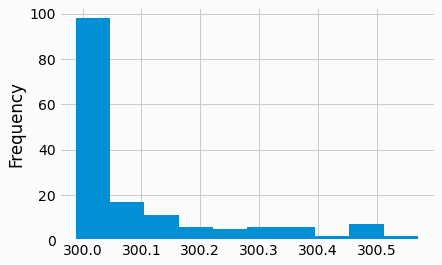

In [23]:
get_results['duration'].plot.hist()

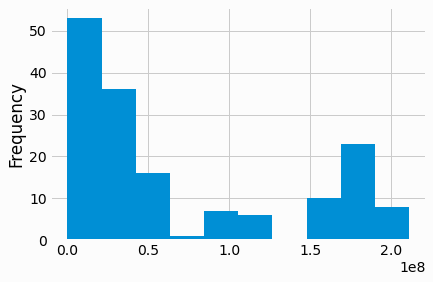

In [24]:
get_results['get_keys'].plot.hist()

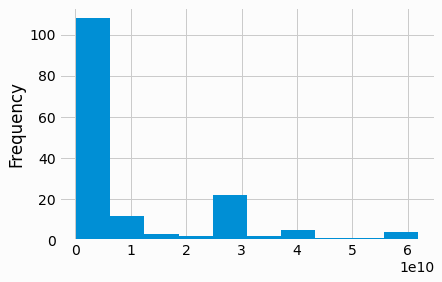

In [25]:
get_results['get_values'].plot.hist()

,count,mean,std,min,25%,50%,75%,max
get_key_rate,160.0,230.539126,238.236827,0.842407,40.01403,103.926443,508.029044,703.454866


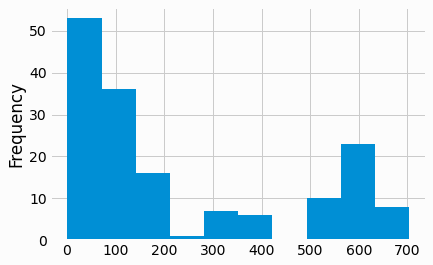

In [26]:
get_results['get_key_rate'] = get_results['get_keys'] / get_results['duration']
display(get_results['get_key_rate'].div(1e3).describe().to_frame().T)
get_results['get_key_rate'].div(1e3).plot.hist()

,count,mean,std,min,25%,50%,75%,max
get_value_rate,160.0,35.758591,47.926021,0.401781,6.318986,12.871413,41.329132,205.671415


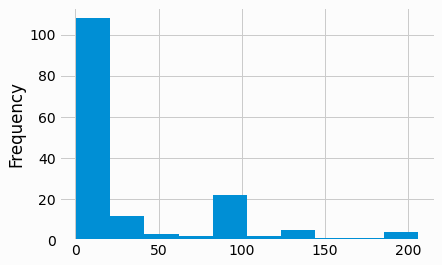

In [27]:
get_results['get_value_rate'] = get_results['get_values'] / get_results['duration']
display(get_results['get_value_rate'].div(1e6).describe().to_frame().T)
get_results['get_value_rate'].div(1e6).plot.hist()

count          mean  std           min           25%           50%           75%           max
key_attr  partitions index_rate                                                                                                
subreddit 1          100          10.0  1.323917e+09  0.0  1.323917e+09  1.323917e+09  1.323917e+09  1.323917e+09  1.323917e+09
                     50           10.0  1.323945e+09  0.0  1.323945e+09  1.323945e+09  1.323945e+09  1.323945e+09  1.323945e+09
          8          10           10.0  1.324152e+09  0.0  1.324152e+09  1.324152e+09  1.324152e+09  1.324152e+09  1.324152e+09
          4          10           10.0  1.324156e+09  0.0  1.324156e+09  1.324156e+09  1.324156e+09  1.324156e+09  1.324156e+09
          2          10           10.0  1.324161e+09  0.0  1.324161e+09  1.324161e+09  1.324161e+09  1.324161e+09  1.324161e+09
          1          10           10.0  1.324165e+09  0.0  1.324165e+09  1.324165e+09  1.324165e+09  1.324165e+09  1.324165e+09
                     5            10.0  1.324441e+09  0.0  1.324441e+09  1.324441e+09  1.324441e+09  1.324441e+09  1.324441e+09
                     1            10.0  1.326648e+09  0.0  1.326648e+09  1.326648e+09  1.326648e+09  1.326648e+09  1.326648e+09
author    1          100          10.0  1.415533e+09  0.0  1.415533e+09  1.415533e+09  1.415533e+09  1.415533e+09  1.415533e+09
                     50           10.0  1.416725e+09  0.0  1.416725e+09  1.416725e+09  1.416725e+09  1.416725e+09  1.416725e+09
          8          10           10.0  1.425694e+09  0.0  1.425694e+09  1.425694e+09  1.425694e+09  1.425694e+09  1.425694e+09
          4          10           10.0  1.425875e+09  0.0  1.425875e+09  1.425875e+09  1.425875e+09  1.425875e+09  1.425875e+09
          2          10           10.0  1.426138e+09  0.0  1.426138e+09  1.426138e+09  1.426138e+09  1.426138e+09  1.426138e+09
          1          10           10.0  1.426274e+09  0.0  1.426274e+09  1.426274e+09  1.426274e+09  1.426274e+09  1.426274e+09
                     5            10.0  1.438207e+09  0.0  1.438207e+09  1.438207e+09  1.438207e+09  1.438207e+09  1.438207e+09
                     1            10.0  1.533700e+09  0.0  1.533700e+09  1.533700e+09  1.533700e+09  1.533700e+09  1.533700e+09

50%
key_attr  partitions index_rate          
subreddit 1          100         1.323917
                     50          1.323945
          8          10          1.324152
          4          10          1.324156
          2          10          1.324161
          1          10          1.324165
                     5           1.324441
                     1           1.326648
author    1          100         1.415533
                     50          1.416725
          8          10          1.425694
          4          10          1.425875
          2          10          1.426138
          1          10          1.426274
                     5           1.438207
                     1           1.533700

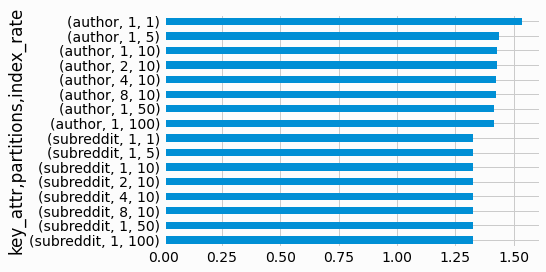

In [28]:
size_stats = (
    get_results
    .groupby(['key_attr', 'partitions', 'index_rate'])
    ['file_size'].describe()
    .sort_values('50%'))
display(size_stats)
display(size_stats['50%'].div(1e9).to_frame())
size_stats['50%'].div(1e9).plot.barh()

In [29]:
(
    get_results
    .groupby(['key_attr','index_rate'])
    ['file_size'].describe()
    .sort_values('50%'))

count          mean            std           min           25%           50%           75%           max
key_attr  index_rate                                                                                                          
subreddit 100          10.0  1.323917e+09       0.000000  1.323917e+09  1.323917e+09  1.323917e+09  1.323917e+09  1.323917e+09
          50           10.0  1.323945e+09       0.000000  1.323945e+09  1.323945e+09  1.323945e+09  1.323945e+09  1.323945e+09
          10           40.0  1.324159e+09    4807.370750  1.324152e+09  1.324155e+09  1.324159e+09  1.324162e+09  1.324165e+09
          5            10.0  1.324441e+09       0.000000  1.324441e+09  1.324441e+09  1.324441e+09  1.324441e+09  1.324441e+09
          1            10.0  1.326648e+09       0.000000  1.326648e+09  1.326648e+09  1.326648e+09  1.326648e+09  1.326648e+09
author    100          10.0  1.415533e+09       0.000000  1.415533e+09  1.415533e+09  1.415533e+09  1.415533e+09  1.415533e+09
          50           10.0  1.416725e+09       0.000000  1.416725e+09  1.416725e+09  1.416725e+09  1.416725e+09  1.416725e+09
          10           40.0  1.425995e+09  228354.395802  1.425694e+09  1.425830e+09  1.426007e+09  1.426172e+09  1.426274e+09
          5            10.0  1.438207e+09       0.000000  1.438207e+09  1.438207e+09  1.438207e+09  1.438207e+09  1.438207e+09
          1            10.0  1.533700e+09       0.000000  1.533700e+09  1.533700e+09  1.533700e+09  1.533700e+09  1.533700e+09

In [30]:
def filter_get_results(key_attr=None, partitions=None, index_rate=None, thread_count=None):
    attr_exprs =  [('key_attr', key_attr),
                   ('partitions', partitions),
                   ('index_rate', index_rate),
                   ('thread_count', thread_count)]
    masks = [create_mask(get_results, attr, expr) for attr,expr in attr_exprs]
    mask = combine_masks(masks)
    if mask is None:
        return get_results
    return get_results[mask]
    

In [31]:
def plot_thread_dependence(ax, df, group_col, y_col='get_key_rate', y_scale=1e-3):
    for partitions, x in df.groupby(group_col):
        x = x.copy()
        x[y_col] *= y_scale
        x = x.sort_values('thread_count')
        x.plot('thread_count', y_col, style='o-', label=str(partitions), ax=ax, ms=10)
        
    ts = sorted(set(x['thread_count']) - {2})
    ax.set_xticks(ts)
    ax.set_xlabel('Concurrent Reading Threads')
    

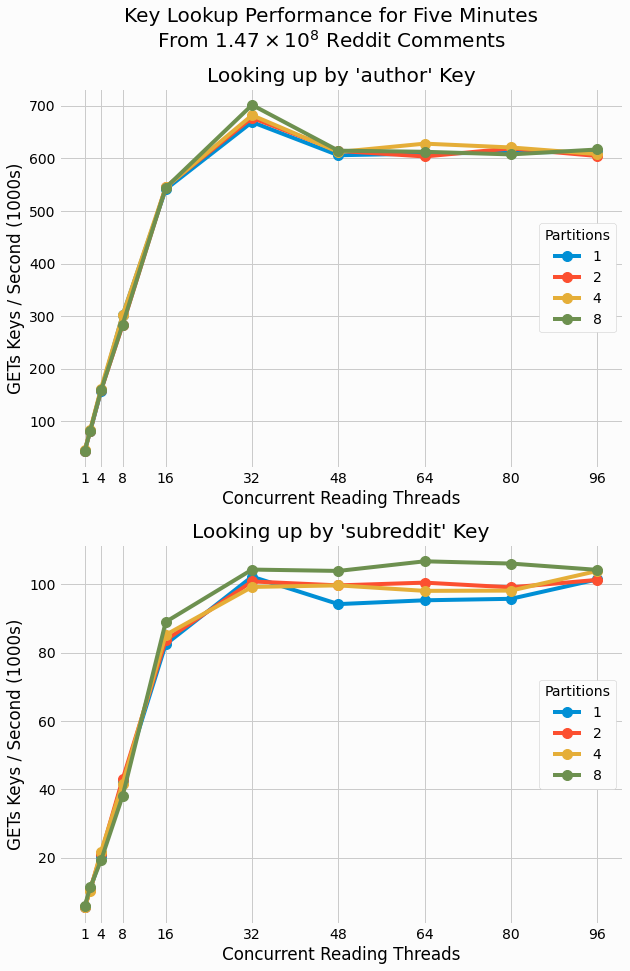

In [32]:
fig = plt.figure(figsize=(9, 14))
ax1 = fig.add_subplot(2, 1, 1)
plot_thread_dependence(ax1, filter_get_results(key_attr='author', index_rate=10), 'partitions')
ax1.set_title('Looking up by \'author\' Key')
ax2 = fig.add_subplot(2, 1, 2)
ax2.set_title('Looking up by \'subreddit\' Key')
plot_thread_dependence(ax2, filter_get_results(key_attr='subreddit', index_rate=10), 'partitions')
for ax in [ax1, ax2]:
    ax.set_ylabel('GETs Keys / Second (1000s)')
    ax.legend(loc='center right', ncol=1, title='Partitions', framealpha=1)

fig.suptitle(f'Key Lookup Performance for Five Minutes\nFrom {format_number(entries)} Reddit Comments',
            size=20)
fig.subplots_adjust(top=0.90)
savefig('get_key_rate_partitions')

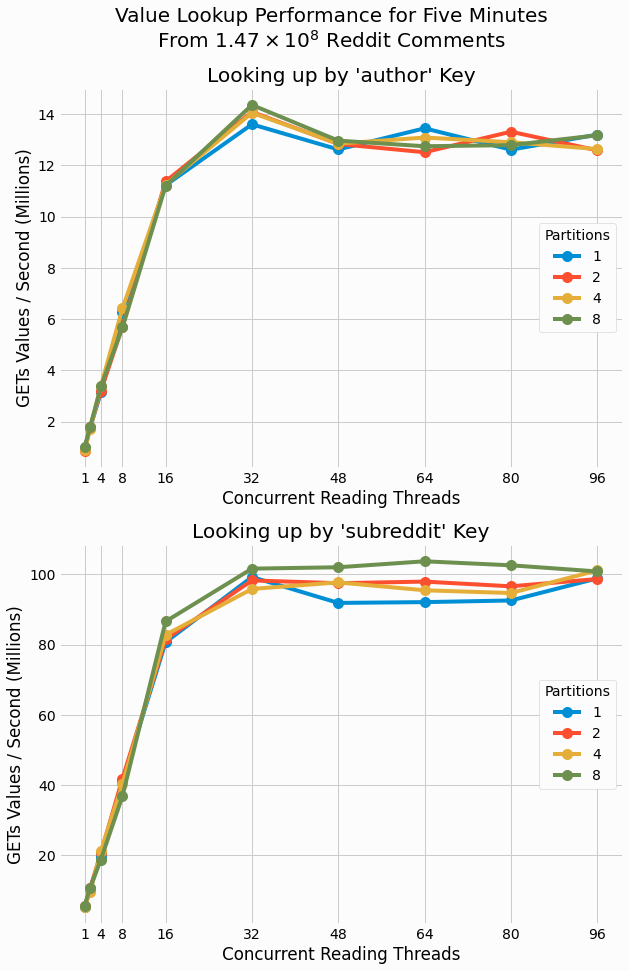

In [33]:
fig = plt.figure(figsize=(9, 14))
ax1 = fig.add_subplot(2, 1, 1)
plot_thread_dependence(ax1, filter_get_results(key_attr='author', index_rate=10), 'partitions',
                       y_col='get_value_rate', y_scale=1e-6)
ax1.set_title('Looking up by \'author\' Key')
ax2 = fig.add_subplot(2, 1, 2)
ax2.set_title('Looking up by \'subreddit\' Key')
plot_thread_dependence(ax2, filter_get_results(key_attr='subreddit', index_rate=10), 'partitions',
                       y_col='get_value_rate', y_scale=1e-6)

for ax in [ax1, ax2]:
    ax.set_ylabel('GETs Values / Second (Millions)')
    ax.legend(loc='center right', ncol=1, title='Partitions', framealpha=1)

fig.suptitle(f'Value Lookup Performance for Five Minutes\nFrom {format_number(entries)} Reddit Comments',
            size=20)
fig.subplots_adjust(top=0.90)
#savefig('get_value_rate_partitions')

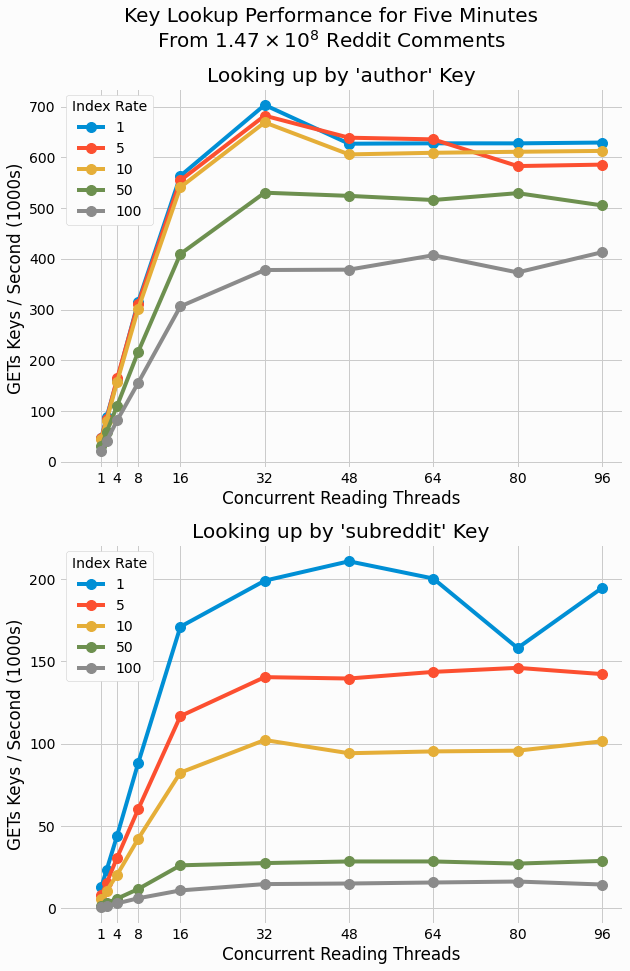

In [34]:
fig = plt.figure(figsize=(9, 14))
ax1 = fig.add_subplot(2, 1, 1)
plot_thread_dependence(ax1, filter_get_results(key_attr='author', partitions=1), 'index_rate')
ax1.set_title('Looking up by \'author\' Key')
ax2 = fig.add_subplot(2, 1, 2)
ax2.set_title('Looking up by \'subreddit\' Key')
plot_thread_dependence(ax2, filter_get_results(key_attr='subreddit', partitions=1), 'index_rate')
for ax in [ax1, ax2]:
    ax.set_ylabel('GETs Keys / Second (1000s)')
    ax.legend(loc='upper left', ncol=1, title='Index Rate', framealpha=1)
    ax.set_xlim(-7, 100)

fig.suptitle(f'Key Lookup Performance for Five Minutes\nFrom {format_number(entries)} Reddit Comments',
            size=20)
fig.subplots_adjust(top=0.90)
savefig('get_key_rate_index_rate')

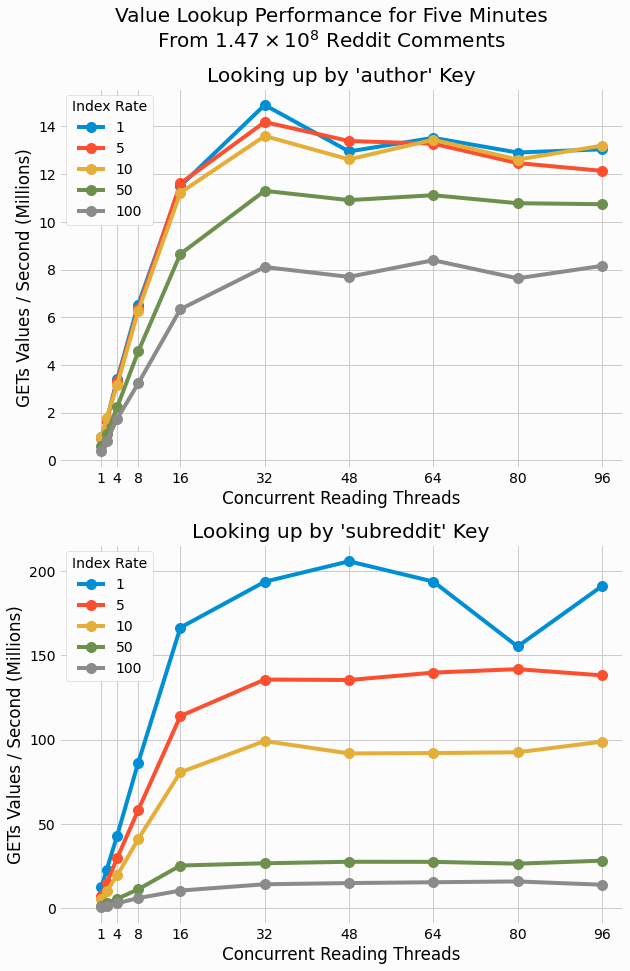

In [35]:
fig = plt.figure(figsize=(9, 14))
ax1 = fig.add_subplot(2, 1, 1)
plot_thread_dependence(ax1, filter_get_results(key_attr='author', partitions=1), 'index_rate',
                        y_col='get_value_rate', y_scale=1e-6)

ax1.set_title('Looking up by \'author\' Key')
ax2 = fig.add_subplot(2, 1, 2)
ax2.set_title('Looking up by \'subreddit\' Key')
plot_thread_dependence(ax2, filter_get_results(key_attr='subreddit', partitions=1), 'index_rate',
                        y_col='get_value_rate', y_scale=1e-6)

for ax in [ax1, ax2]:
    ax.set_ylabel('GETs Values / Second (Millions)')
    ax.legend(loc='upper left', ncol=1, title='Index Rate', framealpha=1)
    ax.set_xlim(-7, 100)

fig.suptitle(f'Value Lookup Performance for Five Minutes\nFrom {format_number(entries)} Reddit Comments',
            size=20)
fig.subplots_adjust(top=0.90)
savefig('get_value_rate_index_rate')

## Analyze Get Latency

In [36]:
percentiles = [0, 10, 25, 50, 75, 90, 95, 99, 99.9, 100]

def compute_combined_bin_latency_percentiles(df):
    t_digest = tdigest_merge(df['t_digest'])
    return pd.Series({p:t_digest.percentile(p) for p in percentiles})

get_combined_stats = (
    get_results
    .set_index(['key_attr', 'partitions', 'index_rate', 'thread_count'])
    ['total_stats']
    .progress_map(compute_combined_bin_latency_percentiles))

get_combined_stats = pd.DataFrame(list(get_combined_stats), index=get_combined_stats.index).reset_index()

get_combined_stats.sample(5)

100%|██████████| 160/160 [00:29<00:00,  5.35it/s]


,key_attr,partitions,index_rate,thread_count,0.0,10.0,25.0,50.0,75.0,90.0,95.0,99.0,99.9,100.0
56,subreddit,1,10,8,0.012611,0.018138,0.019478,0.024658,0.059037,0.225694,0.540146,2.594994,16.390844,559.619507
85,author,1,100,4,0.014443,0.023408,0.030650,0.042729,0.055622,0.067978,0.076417,0.099757,0.198422,877.356750
79,subreddit,2,10,4,0.012040,0.017600,0.018893,0.024003,0.058791,0.238339,0.555716,2.687992,16.241115,583.746033
0,author,8,10,48,0.014460,0.025332,0.032144,0.038035,0.043171,0.050800,0.060644,0.181448,1.700358,1357.351807
138,author,8,10,16,0.014537,0.022122,0.023152,0.024693,0.027165,0.031340,0.035923,0.051541,0.349494,924.116516


In [37]:
get_combined_stats[[0.0, 50.0, 100.0]].describe()

,0.0,50.0,100.0
count,160.000000,160.000000,160.000000
mean,0.014038,0.067085,1355.343453
std,0.001505,0.113296,875.108798
min,0.011155,0.017732,141.207764
25%,0.012818,0.023981,796.141144
50%,0.014063,0.035131,1096.309265
75%,0.015252,0.038422,1705.510223
max,0.017845,0.642795,5133.416992


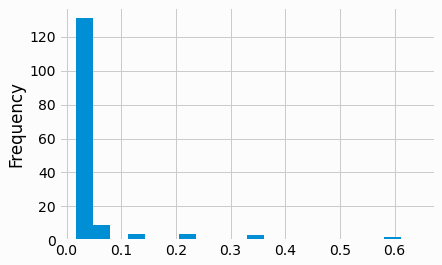

In [38]:
get_combined_stats[50.0].plot.hist(bins=20)

In [39]:
def filter_get_combined_stats(key_attr=None, partitions=None, index_rate=None, thread_count=None):
    attr_exprs =  [('key_attr', key_attr),
                   ('partitions', partitions),
                   ('index_rate', index_rate),
                   ('thread_count', thread_count)]
    masks = [create_mask(get_combined_stats, attr, expr) for attr,expr in attr_exprs]
    mask = combine_masks(masks)
    if mask is None:
        return get_combined_stats
    return get_combined_stats[mask]

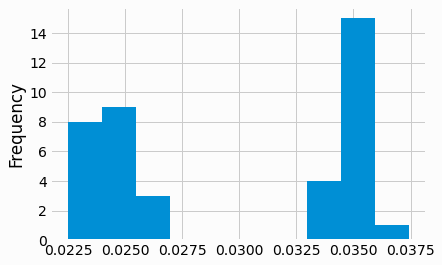

In [40]:
filter_get_combined_stats('subreddit', index_rate=10)[50.0].plot.hist()

In [41]:
latency_outlier_markers = [
    (90.0, '>'),
    (99.9, '^'),
    (100.0, '*')
]

def plot_latency_thread_dependency(ax, df, group_col, legend_label):
    for color, (group_val, group) in zip(colors, df.groupby(group_col)):
        group = group.sort_values('thread_count')
        ts = group['thread_count']
        med = group[50.0]
        p25 = group[25.0]
        p75 = group[75.0]
        
        ax.errorbar(ts, med, [med - p25, p75 - med], marker='o', ls='-', label=str(group_val),
                    ms=5, color=color, elinewidth=2)
        
        for p, m in latency_outlier_markers:
            ax.plot(ts, group[p], color=color, ls='None', marker=m, ms=10)
            
    ax.set_yscale('log')
        
    ts = sorted(set(group['thread_count']) - {2})
    ax.set_xticks(ts)
    ax.errorbar([0], [1], [1], color='k', marker='o', ms=5, elinewidth=2, label='Median &\nInterquartile')
    for p, m in latency_outlier_markers:
        ax.plot([0], [1], color='k', ls='None', marker=m, ms=10, label=f'{p}%', zorder=10)
    ax.set_xlim(0, 140)
    
    ax.set_xlabel('Concurrent Reading Threads')
    ax.set_ylabel('Get Latency (ms)')

    handles, labels = ax.get_legend_handles_labels()
    handles, labels = zip(*sorted(zip(handles, labels), key=lambda p: (not p[1].isdigit(), '%' in p[1])))
    ax.legend(handles, labels, loc='upper right', ncol=1, title=legend_label, framealpha=1)


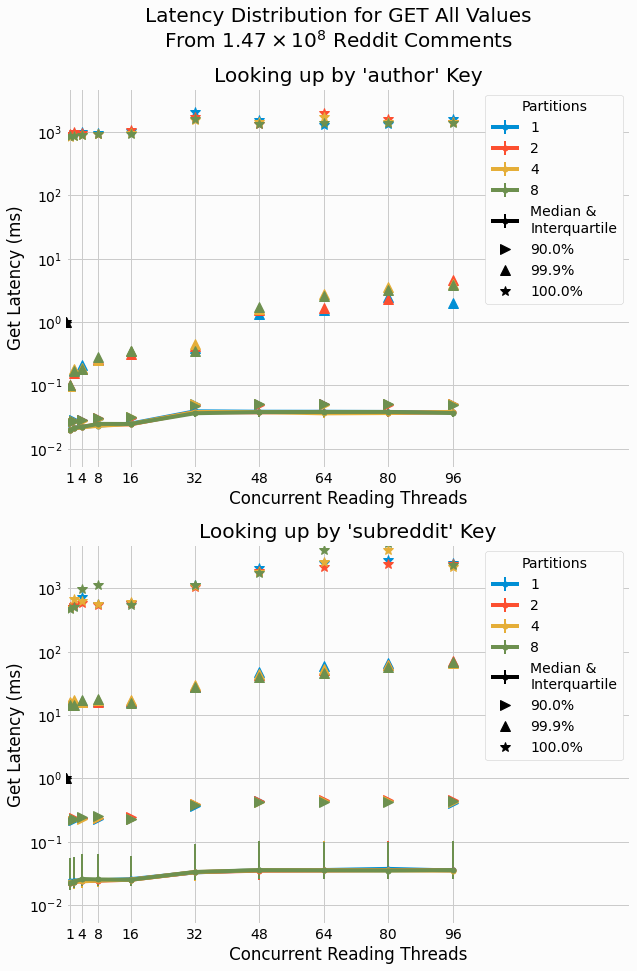

In [42]:
fig = plt.figure(figsize=(9, 14))
for i, key_attr in enumerate(['author', 'subreddit']):
    ax = fig.add_subplot(2, 1, i+1)
    plot_latency_thread_dependency(ax, filter_get_combined_stats(key_attr, index_rate=10),
                                   'partitions', 'Partitions')
    ax.set_title('Looking up by \'' + key_attr + '\' Key')
    ax.set_ylim(5e-3, 5e3)

fig.suptitle(f'Latency Distribution for GET All Values\nFrom {format_number(entries)} Reddit Comments', size=20)
fig.subplots_adjust(top=0.90)


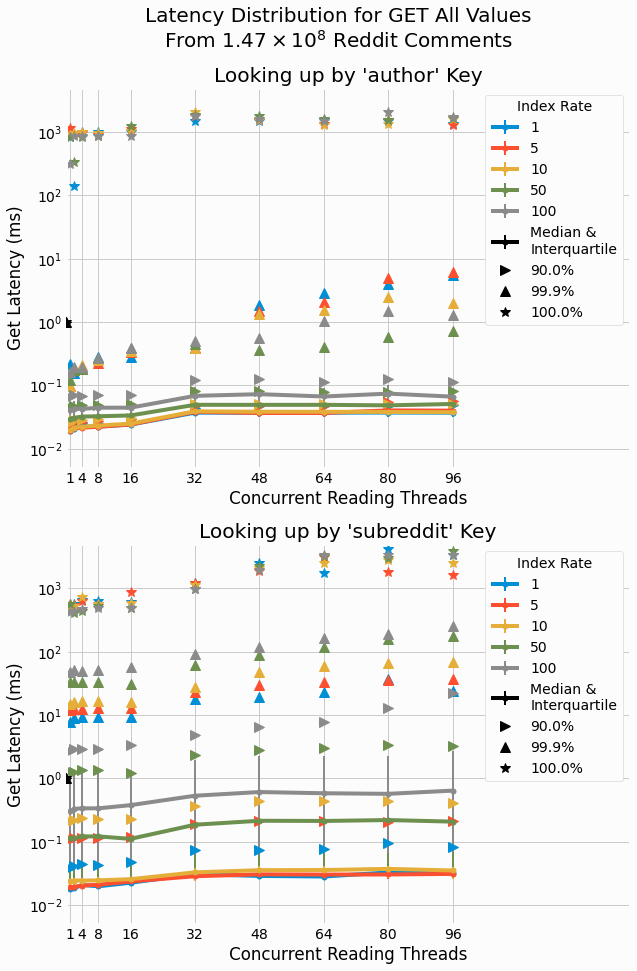

In [43]:
fig = plt.figure(figsize=(9, 14))
for i, key_attr in enumerate(['author', 'subreddit']):
    ax = fig.add_subplot(2, 1, i+1)
    plot_latency_thread_dependency(ax, filter_get_combined_stats(key_attr, partitions=1),
                                   'index_rate', 'Index Rate')
    ax.set_title('Looking up by \'' + key_attr + '\' Key')
    ax.set_ylim(5e-3, 5e3)

fig.suptitle(f'Latency Distribution for GET All Values\nFrom {format_number(entries)} Reddit Comments', size=20)
fig.subplots_adjust(top=0.90)
savefig('get_latency_index_rate')

In [44]:
def get_entry(**kwds):
    df = filter_get_results(**kwds)
    assert len(df) == 1, len(df)
    return df.iloc[0]

column_labels = {
    'key_attr': 'Key',
    'partitions': 'Partitions',
    'index_rate': 'Index Rate',
    'thread_count': 'Threads'
}

def trial_spec_str(trial, columns=None):
    return ' '.join('='.join([column_labels[column], str(trial[column])])
                    for column in (columns or column_labels.keys()))
        
        
def plot_binned_latency(ax, trial):    
    stats = trial['total_stats']
    for _, row in stats.iterrows():
        plot_centroids_cdf(compute_centroids(row['t_digest']), f'{row["floor"]:,}', ax)


    plot_centroids_cdf(compute_centroids(tdigest_merge(stats['t_digest'])), 'Combined', ax, color='k', ls='--')
    ax.set_xscale('log')
    ax.set_xlabel('Latency (ms)')
    ax.set_ylabel('Cumulative Fraction')
    ax.set_xlim(1e-2, 5e8)
    ax.set_xticks(10 ** np.arange(-2, 4.1, 1.0))
    ax.set_yticks(np.arange(0, 1.01, 0.1))
    ax.legend(loc='upper right', ncol=1, title='Bin Floor (Count Observations, Median)', framealpha=1,
              prop={'family': 'monospace'})

def plot_binned_latency_for_key_attrs(partitions, index_rate, thread_count):
    attrs = dict(partitions=partitions, index_rate=index_rate, thread_count=thread_count)
    fig = plt.figure(figsize=(11,14))
    ax1 = fig.add_subplot(2, 1, 1)
    plot_binned_latency(ax1, get_entry(key_attr='author', **attrs))
    ax1.set_title(f'Key=\'author\'')
    ax2 = fig.add_subplot(2, 1, 2)
    plot_binned_latency(ax2, get_entry(key_attr='subreddit', **attrs))
    ax2.set_title(f'Key=\'subreddit\'')
    spec = trial_spec_str(attrs, ["partitions", "index_rate", "thread_count"])
    fig.suptitle(f'Latency for GET All Values, Binned by Value Count\n{spec}', size=20)
    fig.subplots_adjust(top=0.9)


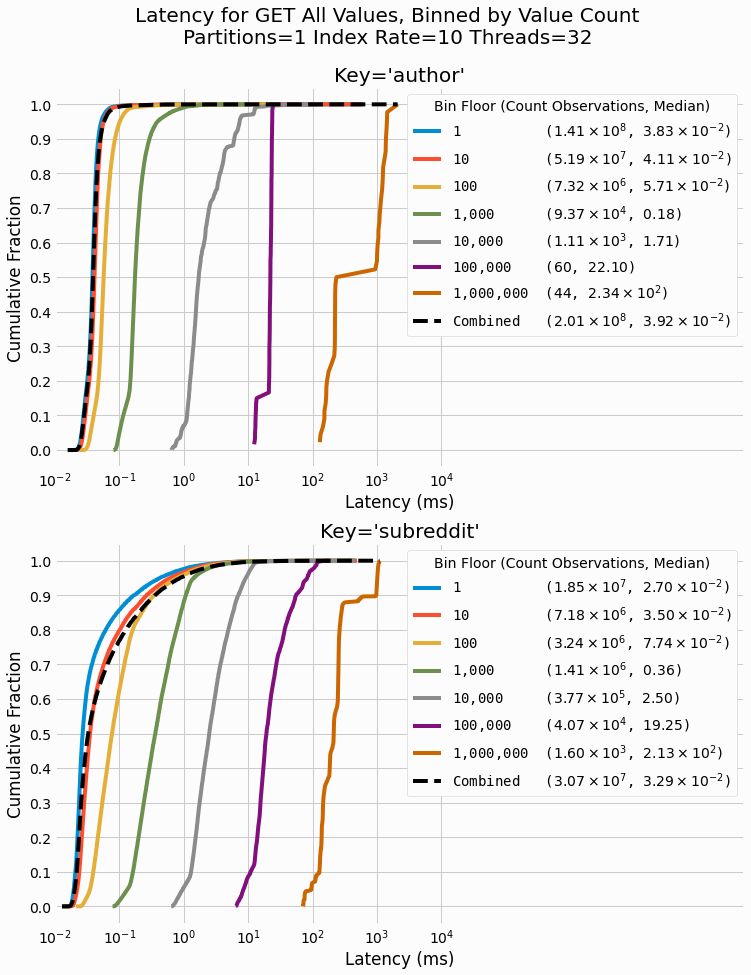

In [45]:
plot_binned_latency_for_key_attrs(1, 10, 32)
savefig('get_binned_latency_p1_i10_t32')


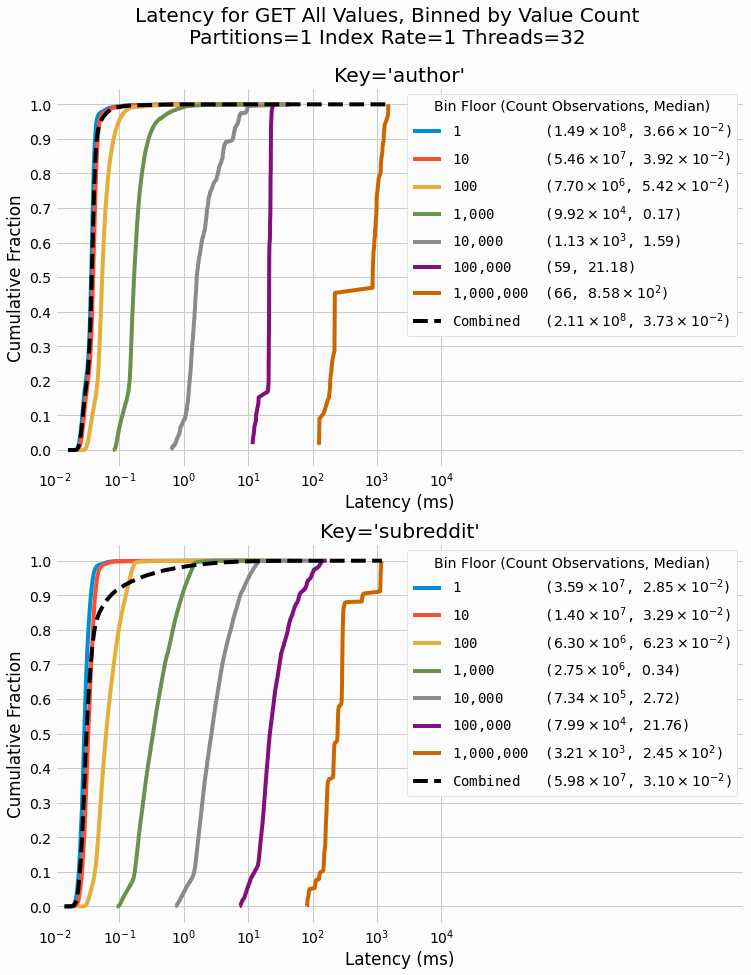

In [46]:
plot_binned_latency_for_key_attrs(1, 1, 32)

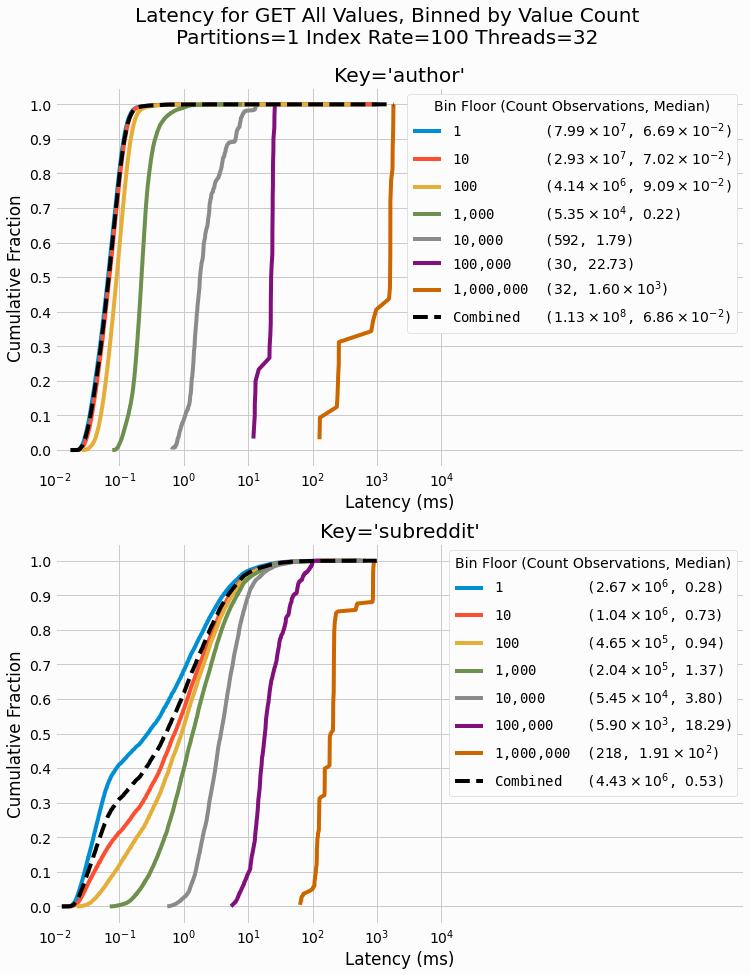

In [47]:
plot_binned_latency_for_key_attrs(1, 100, 32)

In [48]:

def plot_latency_time_dependence(trial):
    df = trial['results']
    df = df.iloc[1:-1:]
    t = df['time'] / 60.0


    stats = df['stats'].map(compute_combined_bin_latency_percentiles)
    stats = pd.DataFrame(list(stats), index=stats.index).reset_index()

    fig = plt.figure(figsize=(9,7))
    ax = fig.add_subplot(111)

    med = stats[50.0]
    p25 = stats[25.0]
    p75 = stats[75.0]

    ax.errorbar(t, med, [med - p25, p75 - med], marker='o', ls='-',
                ms=5, elinewidth=2, lw=2, label='Median &\nInterquartile')

    for p, m in latency_outlier_markers:
        ax.plot(t, stats[p], ls='None', marker=m, ms=10, label=f'{p}%')
    ax.set_yscale('log')
    ax.set_ylabel('Latency (ms)')
    ax.set_xlabel('Time (Minutes)')
    ax.set_xlim(0, 7)
    ax.set_xticks(np.arange(0, 5.1, 1))

    spec = trial_spec_str(trial)
    ax.set_title(f'Latency for GET All Values Over Time\n{spec}')

    handles, labels = ax.get_legend_handles_labels()
    handles, labels = zip(*sorted(zip(handles, labels), key=lambda p: (not p[1].isdigit(), '%' in p[1])))
    ax.legend(handles, labels, loc='upper right', ncol=1, framealpha=1, title='Percentiles')
    


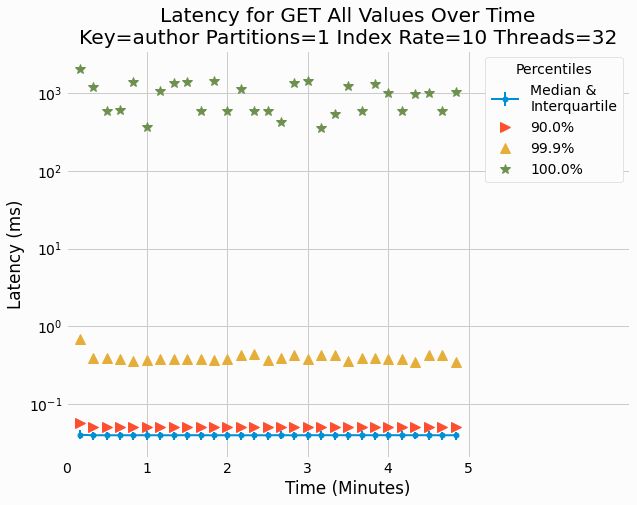

In [49]:
plot_latency_time_dependence(get_entry(key_attr='author', partitions=1, index_rate=10, thread_count=32))
savefig('get_time_dependence_latency_author_p1_i10_t32')


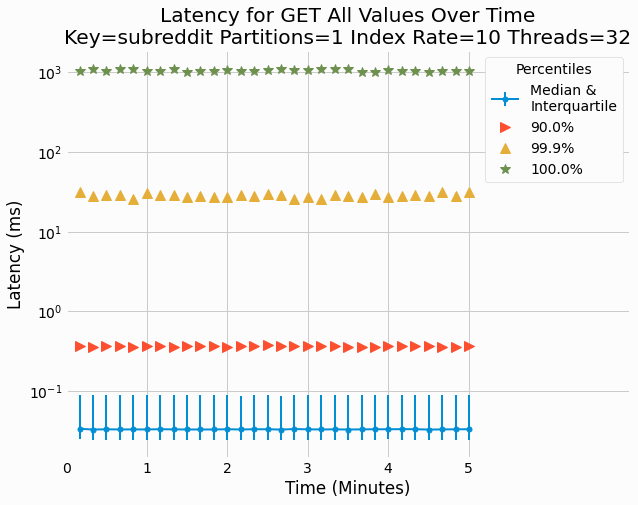

In [50]:
plot_latency_time_dependence(get_entry(key_attr='subreddit', partitions=1, index_rate=10, thread_count=32))

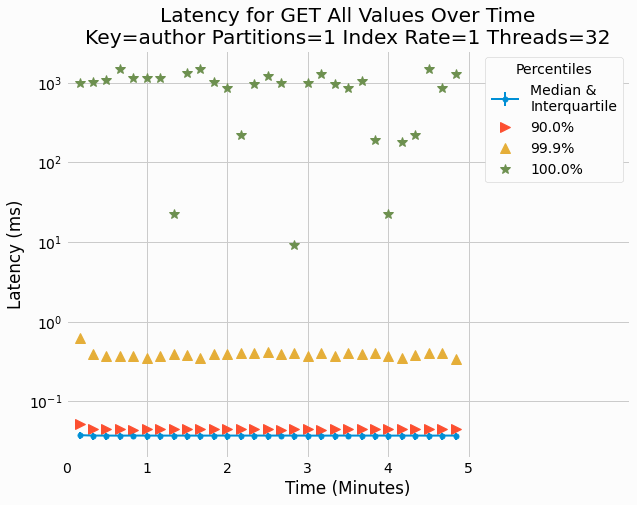

In [51]:
plot_latency_time_dependence(get_entry(key_attr='author', partitions=1, index_rate=1, thread_count=32))

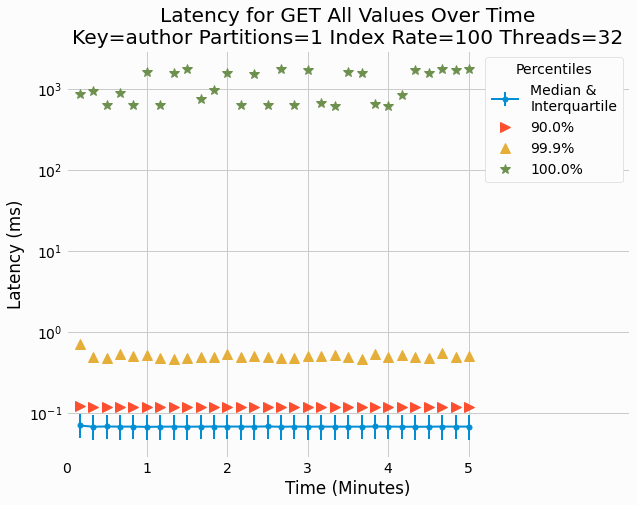

In [52]:
plot_latency_time_dependence(get_entry(key_attr='author', partitions=1, index_rate=100, thread_count=32))